In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import glob 
import seaborn as sns 
import threading
from collections import OrderedDict
from scipy.ndimage import generic_filter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import roc_curve, auc,confusion_matrix,accuracy_score

In [2]:
def read_hgr_images(_dir = "./HGR-dataset/",rate=10):
    names = glob.glob(_dir+"original_images/*")
    names = [name.split("\\")[-1].split(".")[0] for name in names]
    
    imgs = []
    masks = []
    for name in names: 
        img = cv2.imread(_dir+"original_images/{0}.jpg".format(name))
        mask = cv2.imread(_dir+"skin_masks/{0}.bmp".format(name))
        h,w,_ = img.shape 
        img = cv2.resize(img,(w//rate,h//rate),interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask,(w//rate,h//rate),interpolation=cv2.INTER_NEAREST)
        imgs.append(img)
        masks.append(mask)
        
    return imgs,masks 

hgr_imgs,hgr_masks = read_hgr_images()

In [3]:
def make_lut(imgs,masks):
    skin_p = []
    nskin_p = []
    for index in range(len(imgs)):
        img = imgs[index]
        mask = masks[index]
        
        h,w,_ = img.shape 
        img = np.reshape(img,newshape=(w*h,3))
        mask = np.reshape(mask,newshape=(w*h,3))
        mask = mask[:,0]
        
        skin_p.append(img[mask==255,:])
        nskin_p.append(img[mask==0,:])
        
        
    skin_p = np.concatenate(skin_p,axis=0)
    nskin_p = np.concatenate(nskin_p,axis=0)
    
    skin_h = []
    nskin_h = []
    
    for _ in range(3):
        s_h = np.histogram(skin_p[:,_],64,(0,255))[0]
        s_h = s_h/np.sum(s_h)
        skin_h.append(s_h)

        ns_h = np.histogram(nskin_p[:,_],64,(0,255))[0]
        ns_h = ns_h/np.sum(ns_h)
        nskin_h.append(ns_h)
     
    skin_h = np.stack(skin_h,axis=1)
    nskin_h = np.stack(nskin_h,axis=1)
       
    return skin_h,nskin_h
    
hgr_s_h,hgr_ns_h = make_lut(hgr_imgs.copy(),hgr_masks.copy())

In [4]:
def _gen_prop_map_multi(imgs,s,ns,cores,index,new_imgs = {}):
    for i in range(len(imgs)):  
        if i%cores != index:
            continue
        img = imgs[i]
        h,w,_ = img.shape
        new_img = np.zeros((h,w),dtype=np.float64)
        
        for row in range(h):
            for col in range(w):
                pix = img[row,col]
                s_prob = 1
                ns_prob = 1
                for c in range(3):
                    prob_index = int(pix[c]/(255/64))
                    if prob_index == 64 :
                        prob_index = 63 
                    
                    s_prob *= s[prob_index,c]
                    ns_prob *= ns[prob_index,c]

                new_img[row,col] = s_prob/(s_prob+ns_prob)
        new_imgs[i] = new_img

def generate_prop_maps(imgs,s,ns):
        results = {-1:-1}
        Ts = []
        for i in range(20):
            t = threading.Thread(target=_gen_prop_map_multi,args=(imgs,s,ns,20,i,results))
            Ts.append(t)
            
        for t in Ts :
            t.start()
            
        for t in Ts:
            t.join()
         
        del results[-1]  
        return list(dict(OrderedDict(sorted(results.items()))).values())
   
   
def generate_lum_maps(imgs):
    results = []
    for index in range(len(imgs)):
        img = cv2.cvtColor(imgs[index],cv2.COLOR_BGR2GRAY)
        results.append(img)
        
    return results

hgr_prob_maps = generate_prop_maps(hgr_imgs.copy(),hgr_s_h.copy(),hgr_ns_h.copy())
hgr_lum_maps = generate_lum_maps(hgr_imgs.copy())

In [5]:
def dif_max_min(element):
    return np.max(element) - np.min(element)

def _get_fea_vec(img):
    vec = [img]
    for s in [5,9,13]:
        vec.append(generic_filter(img, np.median, size=s))
        vec.append(generic_filter(img, np.min, size=s))
        vec.append(generic_filter(img, np.std, size=s))
        vec.append(generic_filter(img, dif_max_min, size=s))
    return np.stack(vec)
        
def _get_fea_vec_multi(imgs,cores,index,res = {}):
    for i in range(len(imgs)):  
        if i%cores != index:
            continue
        res[i] = _get_fea_vec(imgs[i])
        #print(i)
        

        
def get_fetures_vector(imgs):
    results = {-1:-1}
    Ts = []
    for i in range(20):
        t = threading.Thread(target=_get_fea_vec_multi,args=(imgs,20,i,results))
        Ts.append(t)
    for t in Ts :
        t.start()
    for t in Ts:
        t.join()
        

    del results[-1]  
    return list(dict(OrderedDict(sorted(results.items()))).values())

hgr_feature_vectors = get_fetures_vector(hgr_prob_maps)
hgr_feature_vectors_lum = get_fetures_vector(hgr_lum_maps.copy())

In [6]:
def EigenVectors(trainset,v):
    X_meaned = np.array(trainset) - np.mean(np.array(trainset) , axis = 0)
    cov_mat = np.cov(X_meaned , rowvar = False)
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
    eigen_values = np.abs(eigen_values)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    eigenvectors = eigenvector_subset = sorted_eigenvectors[:,0:v]
    sorted_eigenvalue /= np.max(sorted_eigenvalue)
    sorted_eigenvalue *= 100 
    print(np.round(sorted_eigenvalue,4))
    return eigenvectors.T

def train_LDA(featrues,masks,dim=6,sk=False):
    assert(len(featrues)==len(masks))
    x_train = []
    y_train = []
    for index in range(len(featrues)):
        img_vec = featrues[index]
        mask = masks[index][:,:,0]
        x_train.append(img_vec[:,mask==0])
        x_train.append(img_vec[:,mask==255])
        _0 = img_vec[:,mask==0].shape[1]
        _1 = img_vec[:,mask==255].shape[1]
        y_train.append(np.zeros(_0))
        y_train.append(np.ones(_1))    
    
    x_train = np.concatenate(x_train,axis=1)
    y_train = np.concatenate(y_train)
    x_train = np.transpose(x_train)
    
    # define prior variables 
    WithinScatter = np.zeros((x_train.shape[1], x_train.shape[1]))
    BetweenScatter = np.zeros((x_train.shape[1], x_train.shape[1]))
    FeaturesMean = np.mean(x_train, axis=0)
    
    for label in [0,1]:
        ClassItems = x_train[y_train == label]
        ClassMean = np.mean(ClassItems, axis=0)
        WithinScatter += (np.cov(ClassItems.T))*(len(ClassItems) - 1)

        Count = ClassItems.shape[0]
        MeanDistance = (ClassMean - FeaturesMean).reshape(x_train.shape[1], 1)
        BetweenScatter += Count * (MeanDistance).dot(MeanDistance.T)
       
    # calculate matrix SW^-1 * SB to perform eigenvectors
    SW_1SB = np.linalg.inv(WithinScatter).dot(BetweenScatter)
    LDAs = EigenVectors(SW_1SB,dim) 
    
    if sk :
        lda = LDA()
        lda.fit(x_train,y_train)
        return lda 
    
    return LDAs
    


lda = train_LDA(hgr_feature_vectors.copy(),hgr_masks.copy(),13)

[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


In [99]:
def transform_with_LDA(lda,features,sk=False):
    result = []
    for index in range(len(features)):
        img = features[index]
        _,h,w =  img.shape 
        if sk :
            img = np.reshape(img,(13,-1))
            img = np.transpose(img)
            tran = lda.transform(img)
            new_img = np.reshape(tran,(h,w))
            result.append(new_img)
            continue
        img = np.reshape(img,(13,-1))
        tran = np.dot(lda,img)
        new_img = np.reshape(tran,(lda.shape[0],h,w))
        result.append(new_img)

    return result
        

hgr_lda_transformed = transform_with_LDA(lda,hgr_feature_vectors.copy())
hgr_lda_transformed_lum = transform_with_LDA(lda,hgr_feature_vectors_lum.copy())

In [96]:
def find_ref_and_calculate(vecs,dspfs,count=13):
    results_dis = []
    ref_pix = []
    kernel = np.ones((15, 15), np.uint8)

    for index in range(len(vecs)):
        img = vecs[index]
        dspf = dspfs[index]
        dspf = dspf[:count,:,:]
        _,row,col = img.shape
        prob = img[0].copy()
        prob_ero = cv2.erode(prob,kernel)
        result = np.where(prob_ero == np.amax(prob_ero))
        cord = list(zip(result[0], result[1]))[0]

        ref_values = dspf[:,cord[0],cord[1]]
        tmp = np.transpose(np.tile(ref_values,(col,row,1)),[2,1,0])

        res = (dspf-tmp)**2
        res = np.sum(res,axis=0)
        _m = np.zeros_like(res)
        res = np.sqrt(res)
        _m[:,:] = np.max(res)
        res = (_m-res)/_m

        results_dis.append(res)
        ref_pix.append(cord)
    return results_dis,ref_pix

hgr_dis,hgr_ref_pixs = find_ref_and_calculate(hgr_feature_vectors.copy(),hgr_lda_transformed.copy(),2)


In [106]:
def find_nearest_white(img, target):
    nonzero = cv2.findNonZero(img)
    distances = np.sqrt((nonzero[:,:,0] - target[0]) ** 2 + (nonzero[:,:,1] - target[1]) ** 2)
    nearest_index = np.argmin(distances)
    return nonzero[nearest_index]


def _dp_calculate(dp,source,target,dis,h,y,seed,p_b):
    h = h.astype(np.float64)/255
    y = y.astype(np.float64)/255

    source,target = np.array(source),np.array(target)
    stat = target > source 
    equ = target == source 
    indexes = source.copy()

    if all(equ) :
        return 0 

    flag_dia = 0
    if all(stat) and not (any(equ)):
        indexes += 1
        flag_dia = 1

    elif not any(stat) and not (any(equ)) :
        flag_dia = 1
        indexes -= 1
    else:
        if equ[0]:
            flag_dia += 1
            pass    
        elif stat[0]:
            indexes[0] += 1
        else:
            indexes[0] -= 1

        if equ[1]:
            pass    
        elif stat[1]:
            indexes[1] += 1
            flag_dia += 1
        else:
            indexes[1] -= 1
            flag_dia += 1

    flag_dia = flag_dia%2
    if flag_dia :
        dia = np.sqrt(2)
    else:
        dia = 1


    if dp[indexes[0],indexes[1]] != -1 :
        return dp[indexes[0],indexes[1]] + _dp_calculate(dp,indexes,target,dis,h,y,seed,p_b)

    p1 = dia*(np.abs(y[indexes[0],indexes[1]] - y[source[0],source[1]]) + np.abs(h[indexes[0],indexes[1]] - h[source[0],source[1]]))
    if 1 - dis[indexes[0],indexes[1]] > p_b :
        pp = 1 - dis[indexes[0],indexes[1]]
    else:
        pp = np.inf

    res = p1 * (1+pp)
    dp[indexes[0],indexes[1]] = res
    return dp[indexes[0],indexes[1]] + _dp_calculate(dp,indexes,target,dis,h,y,seed,p_b)

        
def _get_new_dis(seed,dis,h,y,pb):
    dp = np.ones_like(dis,dtype=np.float64)*-1
    #dp[seed==1] = dis[seed==1]
    dp[seed==1] = 0
    R,C = seed.shape 
    for row in range(R):
        for col in range(C):
            if seed[row,col]:
                continue
            source = find_nearest_white(seed,(row,col))[0][::-1]
            target = [row,col]
            _dp_calculate(dp,source,target,dis,h,y,seed,pb)

    _,mask = cv2.threshold(dp,50,1,cv2.THRESH_BINARY_INV)
    return mask,dp

def spatial_anal(distancess,imgs,masks,pb):
    dps,pres,seeds = [],[],[] 
    for index in range(len(distancess)):
        I = index
        _dis = distancess[I]
        img = imgs[I]
        mask = masks[I]

        y = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        h = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)[:,:,0]
        _,seed_img = cv2.threshold(_dis,0.15,1,cv2.THRESH_BINARY)

        seed_img = seed_img*(-1) + 1
        seed_img = (seed_img*255).astype(np.uint8)

        num_labels, labels_im = cv2.connectedComponents(seed_img)
        seed_img = seed_img.astype(np.float64) / 255
        
        unique, counts = np.unique(labels_im.flatten(), return_counts=True)
        counts = dict(zip(unique, counts))
        
        del counts[0]
        _max = max(counts.values())

        for l in range(1,num_labels):
            if _max*0.1 > counts[l]:
                seed_img[labels_im==l] = 0

        pre,dp = _get_new_dis(seed_img.copy(),_dis.copy(),h,y,pb)
        dps.append(dp)
        pres.append(pre)
        seeds.append(seed_img)

        if index == -1:
            plt.imshow(pre,cmap="gray")
            plt.show()
            plt.imshow(img,cmap="gray")
            plt.show()
            plt.imshow(_dis,cmap="gray")
            plt.show()
            
        if (index+1)%50 == 0 :
            print("Passed",index+1)
        
    return pres,dps,seeds
        
hgr_preds, hgr_dp, hgr_seeds = spatial_anal(hgr_dis.copy(),hgr_imgs.copy(),hgr_masks.copy(),0.66)

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_14996\3071527072.py:62: RuntimeWarning: invalid value encountered in double_scalars
  res = p1 * (1+pp)


Passed 50
Passed 100
Passed 150
Passed 200
Passed 250
Passed 300
Passed 350
Passed 400
Passed 450
Passed 500
Passed 550
Passed 600
Passed 650
Passed 700
Passed 750
Passed 800
Passed 850


### ROC

Text(0.5, 1.0, 'ROC chart based on predicted and true mask for images | Error: 13.4%')

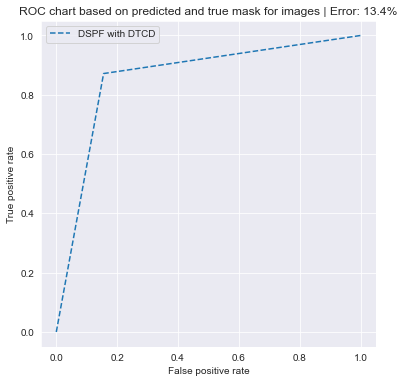

In [107]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (6,6)

sns.set_style("darkgrid")
y_true = []
y_pred = []

for index in range(len(hgr_masks)):
    true_mask = hgr_masks[index][:,:,0].flatten()
    pre_mask = hgr_preds[index].flatten()
    y_pred.append(pre_mask)
    y_true.append(true_mask)


y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
y_true[y_true==255] = 1

y_pred += -1
y_pred = np.abs(y_pred)

ns_fpr,ns_tpr,_ =roc_curve(y_true,y_pred)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='DSPF with DTCD')
cm = confusion_matrix(y_true,y_pred)
cm_f = cm.flatten()
er = (cm[0,1]+cm[1,0])/np.sum(cm)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC chart based on predicted and true mask for images | Error: {0}%".format(round(er*100,2)))

In [117]:
plt.rcParams["figure.figsize"] = (12,12)
def sample_show(Is,m,f,ra=None,lda=False,lum=False):

    plt.rcParams["figure.figsize"] = (12,12)
    if ra is None:
        ra = np.random.randint(0,len(Is)-1)
    plt.subplot(4,4,1)
    plt.imshow(Is[ra][:,:,::-1])
    plt.axis("off")
    
    plt.title("Input Image(DSPF procedure)")
    if lum :
        plt.title("Input Image(DSPF-L procedure)")
    
    
    plt.subplot(4,4,2)
    plt.imshow(m[ra],cmap="gray")
    plt.axis("off")
    plt.title("Mask of image")
    
    if lda :
        index = 3
        for i in range(13):
            plt.subplot(4,4,index)
            index +=1
            plt.imshow(f[ra][i,:,:],cmap="gray")
            plt.axis("off")
            plt.title("DSPS #{0} dim".format(i+1)) 
        plt.tight_layout()     
        plt.show()
        return
            
    plt.subplot(4,4,3)
    plt.imshow(f[ra][0,:,:],cmap="gray")
    plt.axis("off")
    plt.title("Prob. map")
    if lum :
        plt.title("luminance")
    
    index = 5 
    s_i = 0 
    t_i = 0 
    s = ["5*5","9*9","13*13"]
    t = ["Median","Min","STD","MAX-MIN"]
    
    
    for i in range(1,13):
        plt.subplot(4,4,index)
        index +=1
        plt.imshow(f[ra][i,:,:],cmap="gray")
        plt.axis("off")
        plt.title(t[t_i]+" with Kernel "+s[s_i])

        t_i += 1
        if t_i%4==0:
            t_i=0
            s_i +=1
            if s_i%3==0:
                s_i = 0
       
    plt.tight_layout()     
    plt.show()


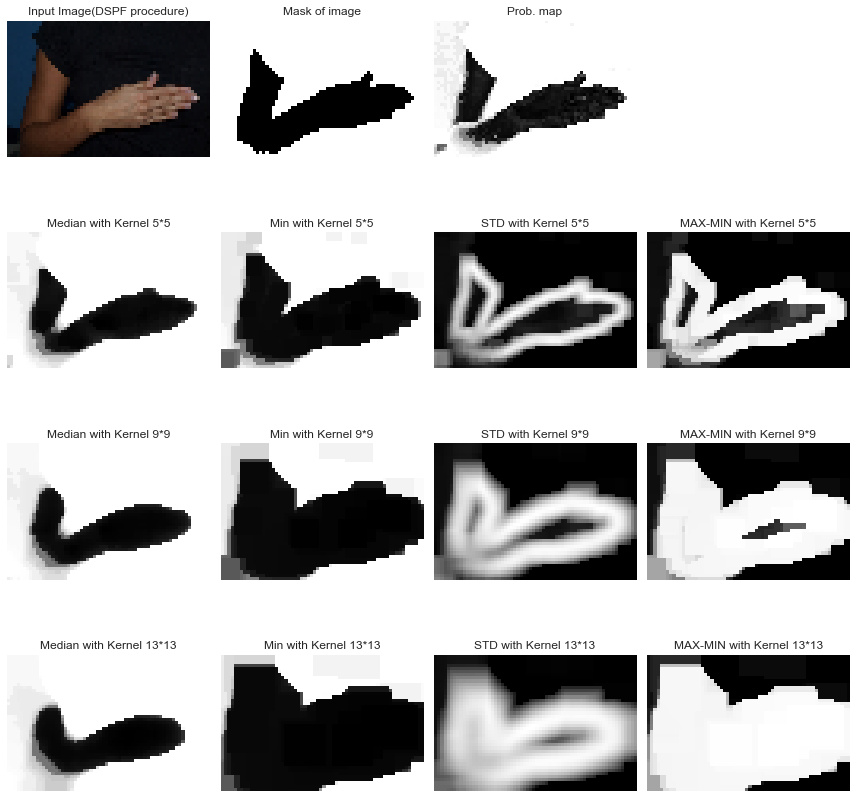

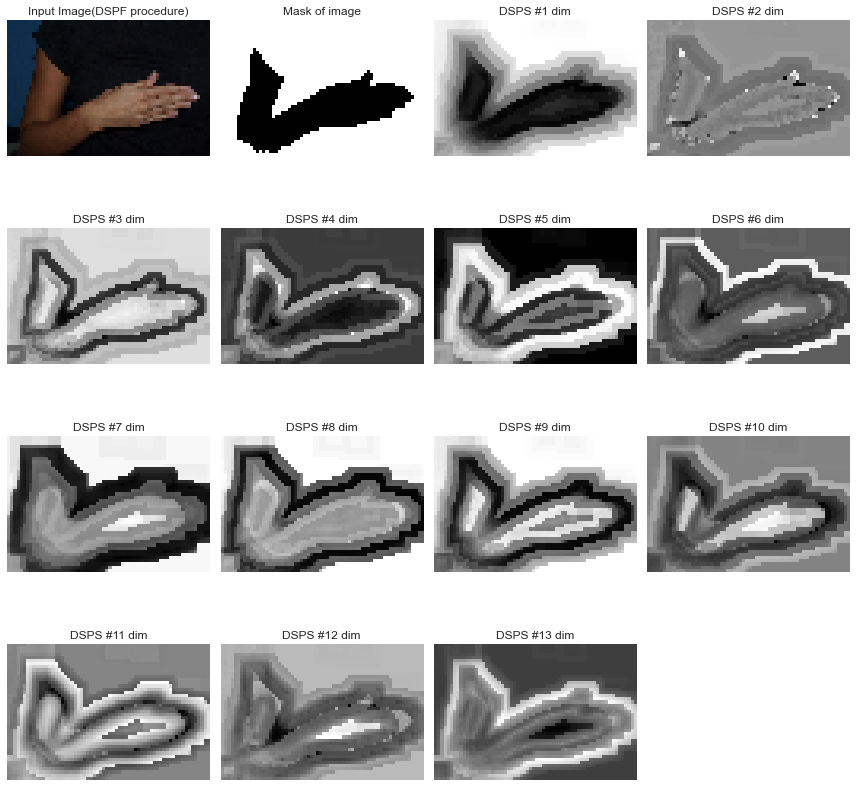

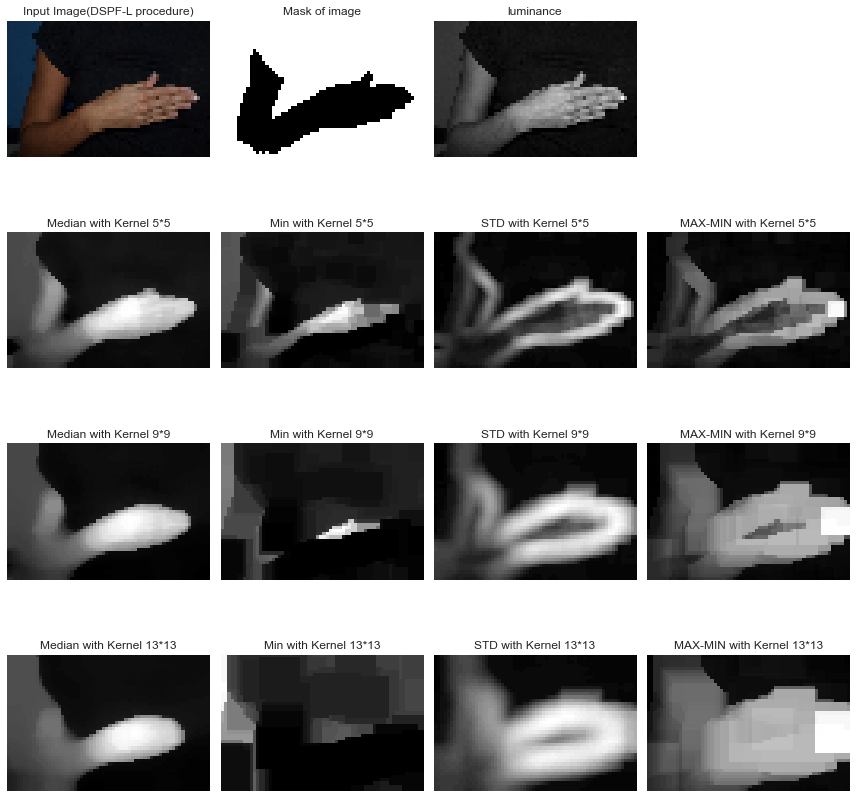

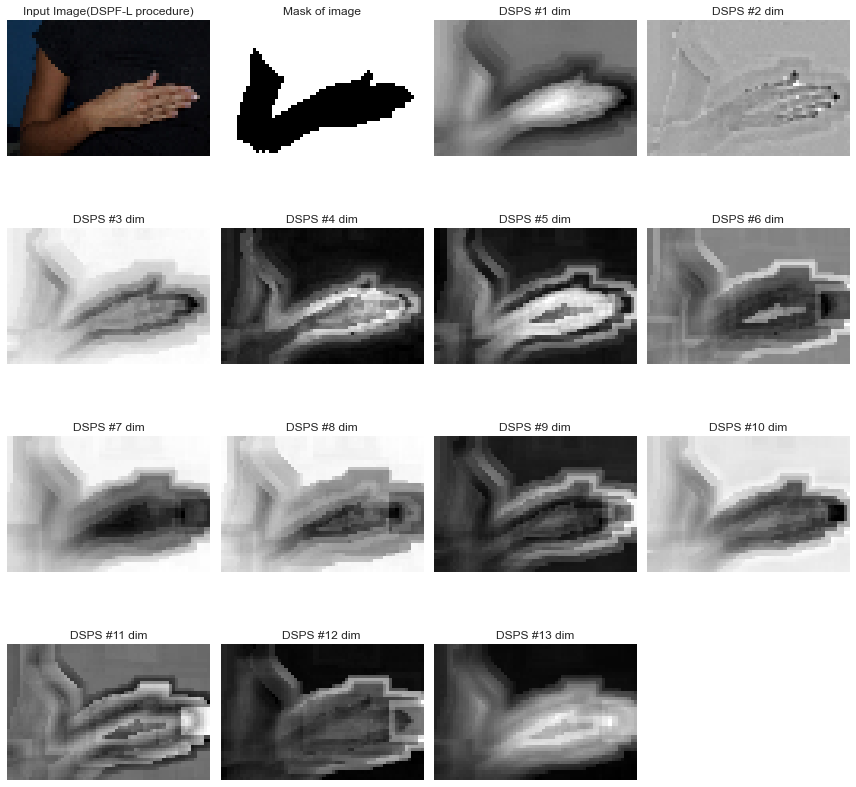

(43, 64)


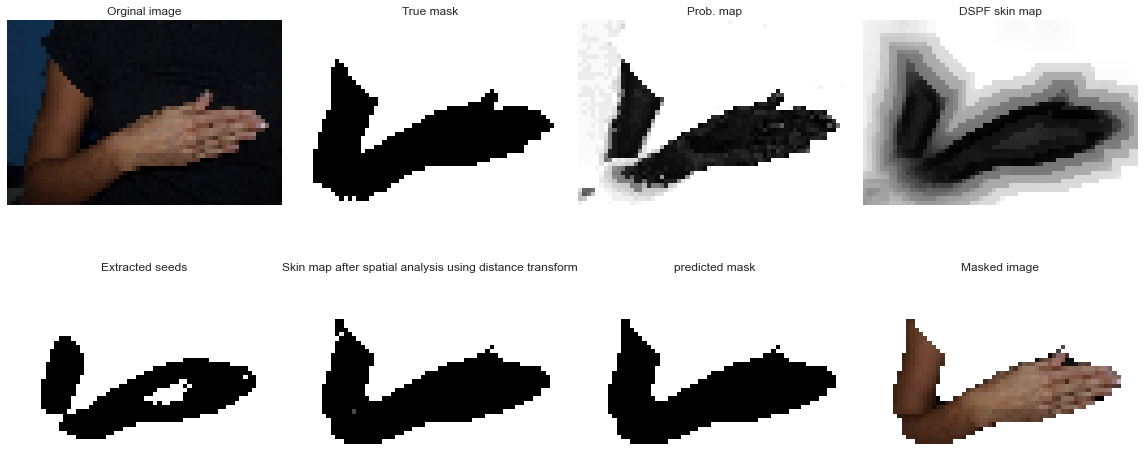

In [128]:
sns.set_style("dark")
def test(index):
    sample_show(hgr_imgs,hgr_masks,hgr_feature_vectors,index)
    sample_show(hgr_imgs,hgr_masks,hgr_lda_transformed,index,True)

    sample_show(hgr_imgs,hgr_masks,hgr_feature_vectors_lum,index,lum=True)
    sample_show(hgr_imgs,hgr_masks,hgr_lda_transformed_lum,index,True,lum=True)

    plt.rcParams["figure.figsize"] = (16,8)
    img = hgr_imgs[index][:,:,::-1]
    h,w,i =2,4,1

    plt.subplot(h,w,i)
    i +=1
    plt.imshow(img)
    plt.title("Orginal image")
    plt.axis("off")

    plt.subplot(h,w,i)
    i +=1
    plt.imshow(hgr_masks[index])
    plt.title("True mask")
    plt.axis("off")

    plt.subplot(h,w,i)
    i +=1
    plt.imshow(hgr_feature_vectors[index][0],cmap="gray")
    plt.title("Prob. map")
    plt.axis("off")
    

    plt.subplot(h,w,i)
    i +=1
    plt.imshow(hgr_dis[index],cmap="gray")
    plt.title("DSPF skin map")
    plt.axis("off")


    plt.subplot(h,w,i)
    i +=1
    plt.imshow(hgr_seeds[index]*-1,cmap="gray")
    plt.title("Extracted seeds")
    plt.axis("off")


    plt.subplot(h,w,i)
    i +=1
    plt.imshow(hgr_dp[index],cmap="gray")
    plt.title("Skin map after spatial analysis using distance transform")
    plt.axis("off")

    plt.subplot(h,w,i)
    i +=1
    plt.imshow(hgr_preds[index]*-1,cmap="gray")
    plt.title("predicted mask")
    plt.axis("off")



    hgr_pred = hgr_preds[index].copy()
    hgr_pred = (hgr_pred*255).astype(np.uint8)
    res = np.zeros_like(img)

    for _ in range(3):
        res[:,:,_] = cv2.bitwise_and(img[:,:,_].copy(),img[:,:,_].copy(),mask=hgr_pred.copy())
        res[:,:,_]==0
    plt.subplot(h,w,i)
    i +=1
    c0 = res[:,:,0]==0
    c1 = res[:,:,1]==0
    c2 = res[:,:,2]==0
    C = c0 & c1 & c2
    res[C] = 255
    print(C.shape)
    plt.imshow(res,cmap="gray")
    plt.title("Masked image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



test(540)

Text(0.5, 1.0, 'ROC chart based on predicted and true mask for images')

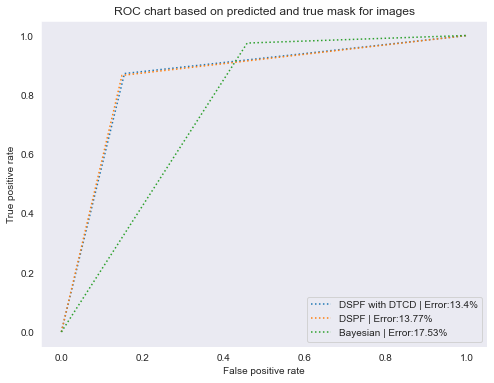

In [244]:
plt.rcParams["figure.figsize"] = (8,6)

def get_bay_pre(rate=0.65):
    pre = []
    masks = []
    for i in range(len(hgr_prob_maps)):
        prob = np.abs(hgr_feature_vectors[i][0] - 1)
        res = prob.copy()
        res[prob>rate] = 0
        res[prob<=rate] = 1
        pre.append(res.flatten())
        masks.append(hgr_masks[i][:,:,0].flatten()/255.)
    return np.concatenate(pre),np.concatenate(masks)

def get_dsfp_pre(rate=0.65):
    pre = []
    masks = []
    for i in range(len(hgr_prob_maps)):
        prob = np.abs(hgr_dis[i] - 1)
        res = prob.copy()
        res[prob>rate] = 0
        res[prob<=rate] = 1
        pre.append(res.flatten())
        masks.append(hgr_masks[i][:,:,0].flatten()/255.)
    return np.concatenate(pre),np.concatenate(masks)




fprs , tprs = [ns_fpr],[ns_tpr]
pre = [y_pred]

a,b = get_dsfp_pre()
fpr,tpr,_ =roc_curve(b,a)
fprs.append(fpr)
tprs.append(tpr)
pre.append(a)


a,b = get_bay_pre()
fpr,tpr,_ =roc_curve(a,b)
fprs.append(fpr)
tprs.append(tpr)
pre.append(a)


Labels = ['DSPF with DTCD | Error:{0}%','DSPF | Error:{0}%','Bayesian | Error:{0}%']

for i in range(3):
    cm = confusion_matrix(y_true,pre[i])
    cm_f = cm.flatten()
    er = (cm[0,1]+cm[1,0])/np.sum(cm)
    plt.plot(fprs[i], tprs[i], linestyle='dotted', label=Labels[i].format(round(er*100,2)))

plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC chart based on predicted and true mask for images")
